# Análisis de registros electrofisiológicos de Neuronas del Giro dentado mediante técnicas de Aprendizaje No supervisado

El objetivo de esta notebook es poder hacer un análisis multivariado de los registros de patch-clamp, pudiendo evaluar el efecto de determinadas drogas (en este ejemplo Montelukast) de forma multiparámetrica.

## Librerías utilizadas

In [1]:
# Cargamos las librerías necesarias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

## Cargamos los datos de las células registradas

In [2]:
# Especialidades
url = 'https://raw.githubusercontent.com/el-asu/Electrophysiology_Non-suppervised/refs/heads/main/Data.csv'
neu_data = pd.read_csv(url, index_col=0)

## Preprocesamiento de datos

Necesitamos preprocesar los datos para poder aplicar los métodos de análisis:

- Seleccionar las variables numéricas.
- Normalizado y escalado (StandardScaler).

In [3]:
# De qué tipo es cada variable
print(neu_data.dtypes)
num_types = ['int64', 'float64']

# Creamos otro DF con las variables numéricas
neu_data_num = neu_data.select_dtypes(include=num_types)

Código de neurona     object
Zona                  object
Condición             object
Vresting               int64
Reobase              float64
Input Resistance     float64
No PA en 80pA          int64
Half-Wide 1ºPA       float64
Max Rise Repol       float64
Max Rise Depol       float64
V max                float64
V thr                float64
I al holding           int64
Sweep para 80pA        int64
Sweep para 100pA       int64
dtype: object


In [4]:
# Utilizamos el StandardScaler para poder normalizar y escalar los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(neu_data_num)

El StandardScaler lo que hace es:
- Para cada variable calcula la media y se la resta a cada valor, por lo que la nueva media queda en cero.
- Para cada variable calcula la SD y divide cada valor por ella, por lo que los valores resultantes son las SD que esa muestra se aleja de la media. 

En líneas generales esto ayuda a que podamos "comparar" numéricamente el efecto en una variable con el efecto en otra.

## Clustering Jerárquico

In [5]:
# Instanciamos el modelo

ward = AgglomerativeClustering(linkage= 'ward', n_clusters=None, distance_threshold=0)
ward_etiquetas = ward.fit_predict(scaled_data)

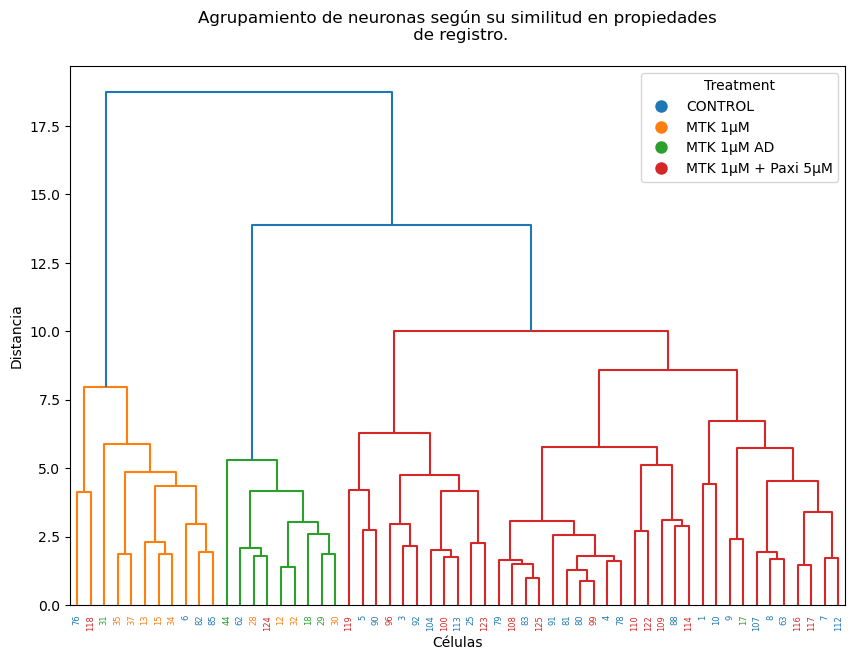

In [6]:
# Creamos el dentrograma utilizando la función linkage de scipy (que ya computa la matriz de connexión completa)
# Es equivalente a usar el método de arriba pero sin tener que calcular la matriz.

Z = linkage(scaled_data, method='ward')

# Map treatments to colors
unique_treatments = neu_data['Condición'].unique()
color_map = dict(zip(unique_treatments, plt.cm.tab10.colors[:len(unique_treatments)]))


plt.figure(figsize=(10, 7))
dendrogram(Z, labels=neu_data.index.tolist(), leaf_rotation=90)
plt.title("Agrupamiento de neuronas según su similitud en propiedades\n de registro.\n")
plt.xlabel("Células")
plt.ylabel("Distancia")

# Apply colors to labels based on treatment
ax = plt.gca()
labels = ax.get_xmajorticklabels()
for label in labels:
    treatment = neu_data.loc[int(label.get_text()), 'Condición']
    label.set_color(color_map[treatment])

# Add legend explaining color notation
legend_elements = [Line2D([0], [0], marker='o', color='w', label=treatment,
                          markerfacecolor=color, markersize=10) 
                   for treatment, color in color_map.items()]
plt.legend(handles=legend_elements, title="Treatment", loc="upper right")

plt.show()

**Interpretación de un dendrograma**: 

El algoritmo utilizado lo que hace es calcular la distancia entre las células en un espacio N dimensional (donde N son el número de parámetros numéricos que le asignamos), luego va juntando cada par de células más cercanas y forma un clúster. Luego busca el clúster más cercano y forma uno nuevo, así sucesivamente hasta formar un único clúster. 
Cuanto más altas son las líneas de unión significa que la distancia entre los elementos del clúster es mayor (son más distintos).

Es importante tener en cuenta que esto se realiza sobre datos normalizados y escalados, por lo que ninguna variable tiene más peso sólo por ser numéricamente mayor.
 

**Interpretación resultados del dataset**:

Se puede ver que las células control y MTK + Paxi se agrupan casi indistintamente. Luego en similitud hay otro grupo bastante heterogéneo pero donde se ubica la mayoría de las células MTK AD, y por último el grupo más distante es uno donde prevalecen las células tratadas con MTK sólo.

## Visualización mediante embeddings

Los embeddings son métodos para poder visualizar en un plano (2D) o en un espacio (3D) un conjunto de muestras con numerosas variables. Por lo que hacen uso de métodos de reducción de dimensionalidad.

### Análisis de componentes principales (PCA - del inglés)

El análisis por componentes principales lo que hace es crear variables artificiales (componentes principales - PC), compuestas por múltiples variables de origen, de forma tal de poder explicar la mayor proporción de la variaza total de la muestra.

In [7]:
pca= PCA(n_components=2) #elegimos 2 que son los que utilizaremos para graficar.

neu_pcas = pca.fit_transform(scaled_data) # Utilizamos los datos provenientes del standard scaler

# proporción de varianza
print('proporción de varianza por componente: ', pca.explained_variance_ratio_)
# proporción de varianza acumulada
print ('proporción de varianza por componente acumulada: ', pca.explained_variance_ratio_.cumsum())

print ('tamaño de los datos: ', neu_pcas.shape)

proporción de varianza por componente:  [0.34712746 0.24105162]
proporción de varianza por componente acumulada:  [0.34712746 0.58817908]
tamaño de los datos:  (57, 2)


Esto significa que entre los dos PC pueden "explicar" un 59% de la varianza total de la muestra, lo cual es relativamente bueno.

In [8]:
# Sumamos los CP al resto de los datos, incluyendo los clusters

neu_PCA = neu_data.copy()
neu_PCA['PC1'] = list(neu_pcas[:,0])
neu_PCA['PC2'] = list(neu_pcas[:,1])

In [9]:
import plotly.express as px

# Create a Plotly scatter plot
fig = px.scatter(
    neu_PCA,
    x='PC1',
    y='PC2',
    hover_name='Condición',  # Display the index when hovering
    title='Componentes principales de las neuronas registradas',
    color='Condición',
    #size = 'Condición', El tamaño también puede codificar otra variable
    opacity = 0.7
)

# Set a fixed size for all dots
fig.update_traces(marker=dict(size=12))  # Adjust the size value as desired


# Show the interactive plot
fig.show()

## KMeans Clustering

Con esta método lo que vamos a hacer es decirle a priori en cuántos grupos (clusters) queremos que divida nuestras muestras, y este lo hará en base a todos los valores numéricos ya normalizados.

Esperaríamos que la clusterización reproduzca la división en tratamientos.

In [10]:
# Entrenamos el dataset para 4 clusters

neu_km4 = KMeans(n_clusters= 4)
neu_km4.fit(scaled_data) #utiliza todas los atributos numéricos seleccionados

# Etiquetas asignadas por el algoritmo
clusters_4 = neu_km4.labels_
print('Suma de los cuadrados de las distancias al centro de cada cluster(5)=Inertia= ', neu_km4.inertia_)

Suma de los cuadrados de las distancias al centro de cada cluster(5)=Inertia=  359.60341735775694


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [11]:
# Agregamos al df los clusters asignados
neu_PCA_KM = neu_PCA.copy()
neu_PCA_KM['kmeans_4'] = neu_km4.labels_ #clusters

In [12]:
# Vemos rápidamente cómo se distribuyen los clusters según región para Kmeans = 4
print('Distribución de clusters por tratamiento KMeans = 4\n   Col izq. = Nro de cluster\n   Col der.= Tratamiento')
neu_PCA_KM.groupby('Condición')['kmeans_4'].value_counts()

Distribución de clusters por tratamiento KMeans = 4
   Col izq. = Nro de cluster
   Col der.= Tratamiento


Condición           kmeans_4
CONTROL             1           13
                    0           10
                    3            4
                    2            1
MTK 1µM             3            5
                    2            4
MTK 1µM + Paxi 5µM  1            8
                    0            3
                    2            3
                    3            1
MTK 1µM AD          2            2
                    0            1
                    1            1
                    3            1
Name: count, dtype: int64

Vamos a visualizar esto mismo, ver cómo se reparten las células de cada condición entre los clusters.

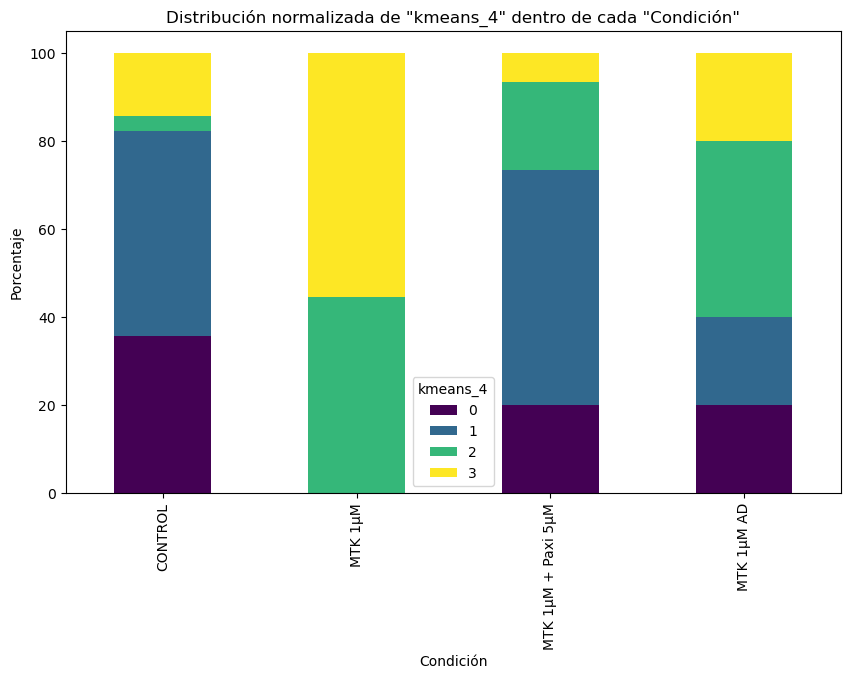

In [13]:
# Step 1: Calculate counts of each 'kmeans_4' within each 'Condición'
grouped = neu_PCA_KM.groupby(['Condición', 'kmeans_4']).size().unstack(fill_value=0)

# Step 2: Normalize counts to get percentages
normalized = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Step 3: Plot the stacked bar chart
ax = normalized.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')

# Add labels and title
ax.set_ylabel('Porcentaje')
ax.set_xlabel('Condición')
ax.set_title('Distribución normalizada de "kmeans_4" dentro de cada "Condición"')

# Add legend and display plot
plt.legend(title='kmeans_4')
plt.show()

La inercia es una métrica del método de KMeans que nos dice de alguna forma cuán "adecuado" es el número de clusters que elegimos para clasificar nuestras muestras. De alguna manera refleja la "homogeneidad" dentro de los clusters. Esta siempre baja conforma aumenta el número de clusters dado que siempre uno mayor permite quedarnos con grupos más homogéneos. En general se toma que el nro ideal es el mínimo con menor inercia, el "codo".

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of

Text(0.5, 1.0, 'Inercia de k-Means versus el número de clusters')

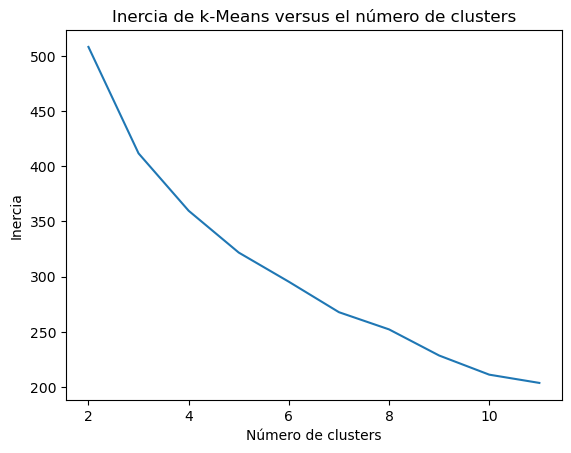

In [14]:
# Gráfico del codo

scores = [KMeans(n_clusters=i).fit(scaled_data).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Número de clusters')
plt.ylabel("Inercia")
plt.title("Inercia de k-Means versus el número de clusters")

Con este gráfico no podemos concluir mucho, dado que no hay una clara inflección en la curva (codo). Lo que podríamos haber esperado es que sea un codo en cuatro, o en 3 si el grupo control se iguala con MKT + Paxi.